# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Decision Tree Classifier to Forecast the Underlying

In this notebook, you will learn to create a decision tree classifier that learns the decision rules from the training data and applies the resultant decision tree over the test data to predict whether the future price of SPY will go up (1) or go down (0) on the upcoming day.

![image.png](https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/Vq3Q8ln8/Predicting-SPY-with-Decision-Tree.jpg)

This notebook is structured as follows:
1. [Import Libraries](#libraries)
2. [Read the Data](#data)
3. [Define the Train and Test data](#train-test)
4. [Decision Tree Classifier](#classifier)
5. [Feature Importance](#feature-imp)
6. [Evaluate Strategy Performance](#evaluate)
7. [Conclusion and Next Steps](#conclusion)

<a id='libraries'></a>
## Import Libraries

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

<a id='data'></a>
## Read the Data

Import the features and target data of the SPY stored in the file `spy_features_target_2009_2022.csv` using the `read_csv` method of `pandas`. The CSV files are available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section.

In [2]:
# Import and display the SPY data along with the features and target
spy = pd.read_csv(
    '../data_modules/spy_features_target_2009_2022.csv', index_col=0)

# Store the features data in variable X
X = spy.filter(like='f_')
X.tail()

,f_ret_1,f_ret_5,f_ret_10,f_ret_22,f_ret_44,f_ret_88,f_natr,f_rsi,f_norm_upper,f_norm_lower,f_norm_middle
Date,,,,,,,,,,,
2022-06-23,0.009803,0.001300,-0.076667,-0.025503,-0.146201,-0.146217,2.564619,41.207044,1.010850,0.955454,0.983152
2022-06-24,0.031794,0.068499,-0.024101,-0.012987,-0.105682,-0.120058,2.528335,49.154390,1.005813,0.925544,0.965679
2022-06-27,-0.003820,0.062128,0.001202,-0.009194,-0.083962,-0.104285,2.428797,48.283114,1.015780,0.946381,0.981080
2022-06-28,-0.020433,0.014877,0.019451,-0.037939,-0.107852,-0.116869,2.539356,43.825117,1.036293,0.972660,1.004477
2022-06-29,-0.000814,0.015892,0.021700,-0.057554,-0.081992,-0.108016,2.432198,43.655645,1.033850,0.982998,1.008424


In [3]:
# Store the target data in variable y
y = spy['target']
y.tail()

Date
2022-06-23    1
2022-06-24    0
2022-06-27    0
2022-06-28    0
2022-06-29    0
Name: target, dtype: int64

<a id='train-test'></a>
## Define the Train and Test data

Generally, you want the training set to be large enough to allow the model to learn from the data, but not so large that it takes a long time to train the model. The test set should be a representative sample of the data that allows you to evaluate the performance of the model on unseen data.

Since we are analysing the properties of SPY over time, you can instead split the data into training and test sets based on time itself. This will ensure that you are preserving the time series order properties present in the data.

For example, you could use the data from the initial few years as the training set and the data from the most recent years as the test set. 
<br>In our case, we can split our dataset in the following manner:

* First 70% of the data will be used for training the model and the remaining data for testing the model.
* `X_train` & `y_train` are the training datasets.
* `X_test` & `y_test` are the test datasets.

In [4]:
# Set the split threshold to 70%
split_percentage = 0.7
split = int(split_percentage*len(X))

# Train dataset
X_train = X[:split]
y_train = y[:split]

# Test dataset
X_test = X[split:]
y_test = y[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2315, 11) (2315,)
(993, 11) (993,)


<a id='classifier'></a>
## Decision Tree Classifier
The `DecisionTreeClassifier` is a class in the `sklearn` library that can be used to train a decision tree model for classification tasks. 

The parameters used in this function are:

1. `max_depth`: It denotes maximum depth of the tree. It takes any integer value. 
2. `min_samples_leaf`: It is the minimum number of samples required to be at a leaf node.
3. `random_state`: Ensures that the model will always produce the same results when trained on the same data. 

In general, your decision tree classifier should not be assigned a very large `max_depth` value as it can make your model prone to overfitting. 

In the below code, we have created a decision tree classifier where the `max_depth` and `min_samples_leaf` are set to 5 and the `random_state` is set to 42. Note that these values were chosen arbitrarily and you can change the values as per your preference.

In [5]:
# Initialise the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)
clf

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

<a id='fit'></a>
### Fit the Decision Tree Classifier

We will create our decision tree classifier model using the `fit` method on the training dataset.

In [6]:
# Train the model on the training set
clf = clf.fit(X_train, y_train)

<a id='accuracy'></a>
### Classifier accuracy

We will compute the accuracy of the algorithm by comparing the actual target values with the predicted values for the train and test data. The function `accuracy_score` will be used to calculate the accuracy.

<B>Syntax:</B> accuracy_score(target_actual_value,target_predicted_value)
1. `target_actual_value`: correct signal values
2. `target_predicted_value`: predicted signal values

In [7]:
# Evaluate the model on the train dataset
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, clf.predict(X_train))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))

# Evaluate the model on the test dataset
accuracy_test = accuracy_score(y_test, clf.predict(X_test))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 59.22%
Test Accuracy: 57.91%


The train and test accuracy values (as shown above) help us get a sense as to how well the model is able to predict the target variable.

<a id='feature-imp'></a>
## Feature Importance

The `feature_importances_` attribute of a `DecisionTreeClassifier` class returns an array that shows the relative importance of each feature in the model. This is calculated based on how much the tree nodes using that feature reduce impurity, with higher values indicating a more important feature.

In the following cell, we have demonstrated an example of how you can use the `feature_importances_` attribute to identify the features that are most important for your model while it makes its predictions.

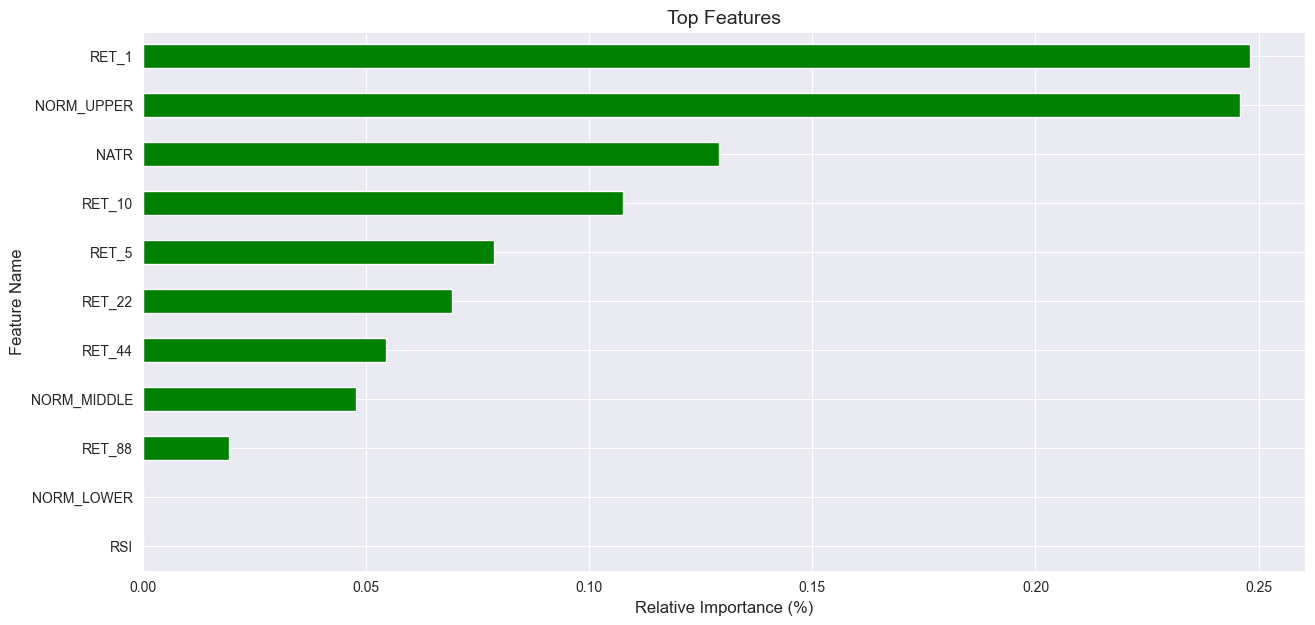

In [8]:
# Initialise the feature labels
labels = X.columns.str.replace('f_', '').str.upper()

# Calculate and sort the feature importances in descending order
feature_importance = (pd.Series(clf.feature_importances_,
                                index=labels).sort_values(ascending=False))

# Plot the feature ranking
plt.figure(figsize=(15, 7))
feature_importance.sort_values().plot.barh(
    title='Feature Importance', color='green')
plt.title(f'Top Features', fontsize=14)
plt.xlabel('Relative Importance (%)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.show()

The above plot shows us that feature `RET_1` is the most important feature, followed by `NORM_UPPER`, and so on, this means that `RET_1` is the most influential feature in this model's predictions and the `RSI` was given the least importance.

<a id='evaluate'></a>
## Evaluate Strategy Performance

### Predict the Signal 

We will store all values of the predicted signal in the dataframe `spy` under the column `predicted_signal`.

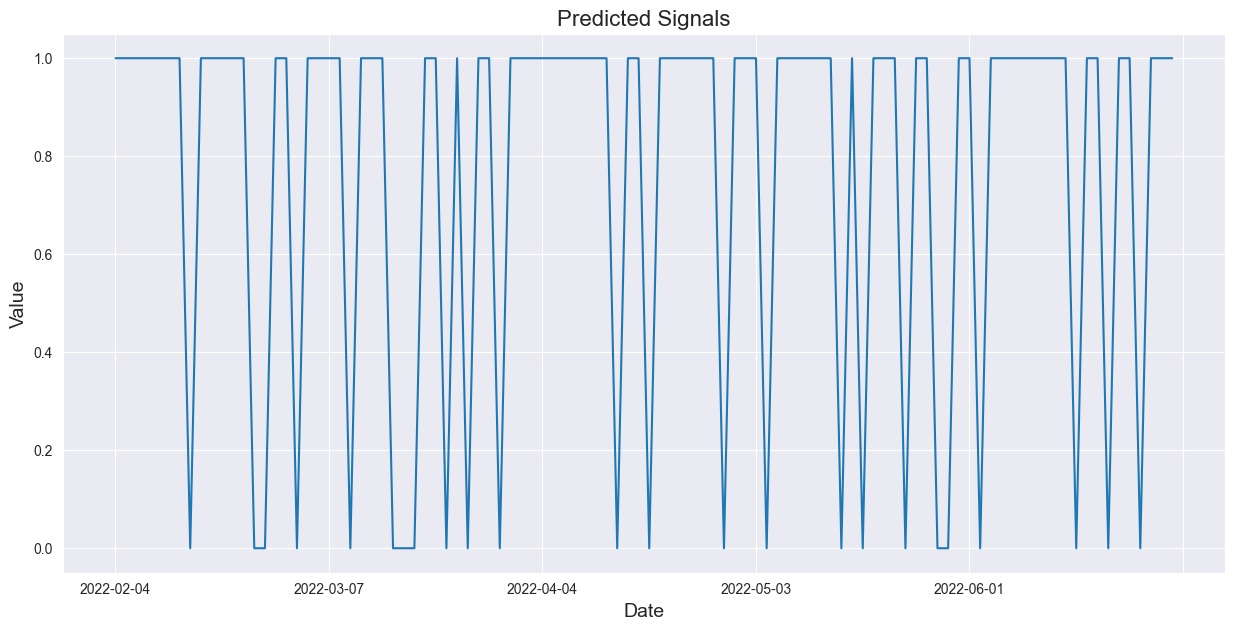

In [9]:
# Compute and store the predicted signal
spy['predicted_signal'] = clf.predict(X)

# Plot the predicted signal
plt.figure(figsize=(15, 7))
spy.iloc[-100:].predicted_signal.plot()

# Set the title and axes labels
plt.title('Predicted Signals', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.show()

### Compute Returns in the Test Period

We will compute and plot the cumulative strategy returns based on the predicted signal.

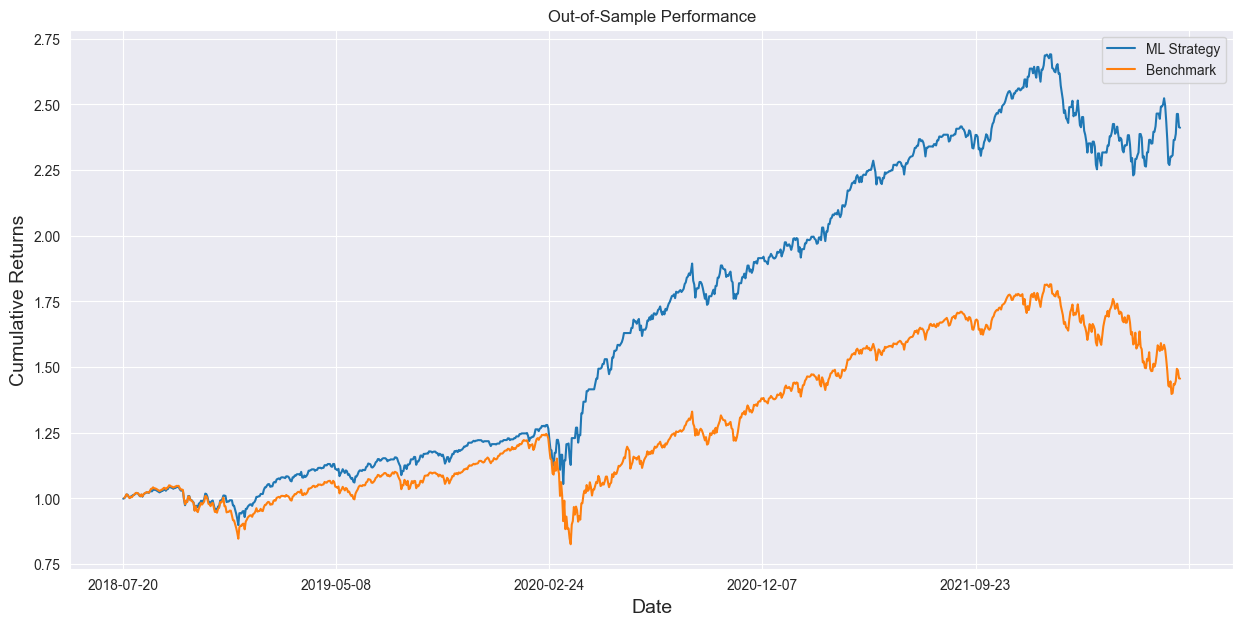

Benchmark Sharpe: 0.54
ML Strategy Sharpe: 1.29


In [10]:
# Calculate strategy returns for out-of-sample period
spy['strategy_returns'] = spy.Close.pct_change() * spy.predicted_signal.shift(1)
test_data = spy.iloc[split:]

# Plot the returns
plt.figure(figsize=(15, 7))
(test_data['strategy_returns']+1).cumprod().plot(label='ML Strategy')
(test_data.Close.pct_change()+1).cumprod().plot(label='Benchmark')

# Set title and legend for the plot
plt.title('Out-of-Sample Performance')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend()
plt.show()

# Function to compute Sharpe ratio
def get_sr(ret):
    return round(ret.mean()/ret.std()*252**0.5, 2)

# Print the Sharpe ratios for the strategies
print(f"Benchmark Sharpe: {get_sr(test_data.Close.pct_change())}")
print(f"ML Strategy Sharpe: {get_sr(test_data['strategy_returns'])}")

In the above plot, you can see how the machine learning strategy has outperformed the benchmark and also obtained a higher sharpe ratio of 1.29 as compared with 0.54 of the benchmark.

### Save the Files on Your Disk

You can run the following code cell in order to store the predictions, expected target and underlying signal data to CSV files as we will be importing the same in the upcoming notebooks.

<b>The following cell will not run in the browser. Download this notebook and convert the cell to "Code" type.</b>

<a id='conclusion'></a>
## Conclusion and Next Steps

So far, you have learned to implement a decision tree classifier model. You have also learned to check the importance given to individual features for the models predictions and you also measured the accuracy of your model over train and test data.

In the next notebook, you will learn a few additional ways to evaluate a classifier. <br><br>